In [1]:


import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
findspark.find()

spark = SparkSession.builder.getOrCreate()
from pyspark.sql.types import *

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/30 16:34:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark

In [3]:
import pyspark.sql.functions as F
from pyspark.sql.types import *

In [4]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn import metrics

import matplotlib.pyplot as plt

# import the required functions
from pyspark.ml.feature import Binarizer, StringIndexer, VectorIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType

# import the required packages
import sparknlp
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF
from sparknlp.base import DocumentAssembler
from pyspark.ml.feature import StopWordsRemover, CountVectorizer

# import the required packages
from pyspark.ml.feature import Word2Vec

import demoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [73]:
import nltk

# firstly download stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /Users/echo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [74]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [5]:
import os 


In [6]:
os.getcwd()

'/Users/echo/Desktop/BigData/Group_Assignment'

## 1.Loading data

In [8]:
# Loading the data as spark caused some weird issues, so we will load the data as pandas and conver to spark
kickstarter_df = pd.read_csv('./data/kickstarter_data.csv', sep = ';').iloc[:,1:]

In [9]:
kickstarter_df.head()

,goal,duration,id,state,creator_name,launched_at,Duration_25_perc,project_url,project_name,project_description,staff_pick,analytics_name,name,parent_name,slug,scrape_date,pledged,backers_count,Days_since_scrape
0,500.0,30,1440011688,successful,Lithiumaniac,2021-04-08,8.0,https://www.kickstarter.com/projects/-aeolus/a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000.0,30,689293158,successful,CYON,2020-05-05,8.0,https://www.kickstarter.com/projects/-cyon-/cy...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18000.0,30,39986636,successful,Dam,2021-04-06,8.0,https://www.kickstarter.com/projects/-myowngam...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000.0,30,520882120,successful,mystiic,2020-10-03,8.0,https://www.kickstarter.com/projects/-mystiic/...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6000.0,30,1347440454,successful,mystiic,2020-04-18,8.0,https://www.kickstarter.com/projects/-mystiic/...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
kickstarter_df.dtypes

goal                   float64
duration                 int64
id                       int64
state                   object
creator_name            object
launched_at             object
Duration_25_perc       float64
project_url             object
project_name            object
project_description     object
staff_pick              object
analytics_name          object
name                    object
parent_name             object
slug                    object
scrape_date             object
pledged                float64
backers_count          float64
Days_since_scrape       object
dtype: object

In [8]:
# String columns cause issues when transforming to spark hence we need to do conversions before changing to spark dataframe
columns_object = list(kickstarter_df.select_dtypes(object).columns)
kickstarter_df[columns_object] = kickstarter_df[columns_object].astype(str)

In [9]:
kickstarter_df =  spark.createDataFrame(kickstarter_df)

In [14]:
twitter_df = pd.read_csv('../tweets_data.csv').iloc[:,1:]

In [15]:
twitter_df.dtypes

full_text                          object
lang                               object
retweet_count                       int64
retweeted                            bool
favorite_count                      int64
tweet_hashtags                     object
tweet_user_mentions_name           object
tweet_user_mentions_screen_name    object
tweet_expanded_url                 object
tweet_followers_count               int64
tweet_friends_count                 int64
user_favourites_count               int64
user_name                          object
user_screen_name                   object
user_description                   object
user_verified                        bool
tweet_date                         object
tweet_source                       object
Long_url                           object
dtype: object

In [16]:
twitter_df.head()

,full_text,lang,retweet_count,retweeted,favorite_count,tweet_hashtags,tweet_user_mentions_name,tweet_user_mentions_screen_name,tweet_expanded_url,tweet_followers_count,tweet_friends_count,user_favourites_count,user_name,user_screen_name,user_description,user_verified,tweet_date,tweet_source,Long_url
0,WarBound #2 is 75% funded. Let's try to get to...,en,9,False,10,[],[],[],http://kck.st/3di41wM,1541,2658,12727,Marcel Dupree,Marcel_Dupree,"Writer, editor and publisher of @Evoluzionepub.",False,2021-04-16,mobile,https://www.kickstarter.com/projects/982272706...
1,"@GibaAmendola , lembrei de vc\nhttps://t.co/b4...",pt,0,False,1,[],['Gilberto Amendola'],['GibaAmendola'],http://kck.st/3uE6p6O,417,1733,35184,cric cric 🖤,crisherrero,"Co founder @caricaturadepet, infographic-mania...",False,2021-04-15,mobile,https://www.kickstarter.com/projects/illustrat...
2,Board game 『#HIZURU』\n24 hours to go until Kic...,en,0,False,2,['HIZURU'],[],[],http://kck.st/3dY0WSe,701,1895,645,【ヒイヅル】Kickstarter挑戦中❗️｜ボードゲームヒーローズ,boardgameheloes,童話のヒーローたちが大集合！#ゲムマライブ で誕生した、鬼退治×ループ型協力ボードゲーム【#...,False,2021-08-26,twitter,https://www.kickstarter.com/projects/boardgame...
3,Missed out on buying the ULTRA-RARE issues? We...,en,6,False,32,"['E1M1Mag', 'Kickstarter']",[],[],http://kck.st/3xR8QEa,6039,1326,8772,E1M1 Magazine ON KICKSTARTER!,E1M1magazine,"E1M1 Magazine, the world's 1st old-school shoo...",False,2021-08-25,mobile,https://www.kickstarter.com/projects/e1m1-maga...
4,Woah! We made some huge progress over on the K...,en,2,False,3,[],[],[],http://kck.st/3xDwN1D,1716,1,6439,Zachary Lucky,zacharylucky,Writer and a rambler from the great Canadian M...,False,2021-08-23,twitter,https://www.kickstarter.com/projects/zacharylu...


In [17]:
twitter_df['tweet_datetime'] = pd.to_datetime(twitter_df['tweet_date'],format = '%Y-%m-%d').astype('str')

# dt.date

In [18]:
# transform some variables to transform to spark dataframe

column_object = list(twitter_df.select_dtypes(object).columns)
twitter_df[column_object] = twitter_df[column_object].astype('str')

In [19]:
twitter_df = spark.createDataFrame(twitter_df)

## 2. Join kickstarter data and tweets together

My idea is to merge the kickstarter data and the tweets, so we can get twittter variables per unique project id and then later on we can left join this data back to the kickstarter data on project id, to get the twitter data per project id. 

In [53]:
# check the shape of dataframe:

print(' the size of kickstarter data',kickstarter_df.count())
print( 'the size of twitter data',twitter_df.count())

22/08/03 15:59:51 WARN TaskSetManager: Stage 18 contains a task of very large size (1896 KiB). The maximum recommended task size is 1000 KiB.
 the size of kickstarter data 28622
22/08/03 15:59:51 WARN TaskSetManager: Stage 21 contains a task of very large size (7093 KiB). The maximum recommended task size is 1000 KiB.
the size of twitter data 57466


In [60]:
kickstarter_df.printSchema()

root
 |-- goal: double (nullable = true)
 |-- duration: long (nullable = true)
 |-- id: long (nullable = true)
 |-- state: string (nullable = true)
 |-- creator_name: string (nullable = true)
 |-- launched_at: string (nullable = true)
 |-- Duration_25_perc: double (nullable = true)
 |-- project_url: string (nullable = true)
 |-- project_name: string (nullable = true)
 |-- project_description: string (nullable = true)
 |-- staff_pick: string (nullable = true)
 |-- analytics_name: string (nullable = true)
 |-- name: string (nullable = true)
 |-- parent_name: string (nullable = true)
 |-- slug: string (nullable = true)
 |-- scrape_date: string (nullable = true)
 |-- pledged: double (nullable = true)
 |-- backers_count: double (nullable = true)
 |-- Days_since_scrape: string (nullable = true)



In [25]:
# get base url: remove '?ref=...'
kickstarter_df = kickstarter_df.withColumn("project_url_base", F.regexp_replace(F.col("project_url"), "\?ref=.*", ""))
twitter_df = twitter_df.withColumn("project_url_base", F.regexp_replace(F.col("Long_url"), "\?ref=.*", ""))

In [28]:
# join these two dataframe by project url

tweets = twitter_df.join( kickstarter_df[['id','goal','pledged','launched_at','backers_count','project_description','project_url_base','creator_name','Days_since_scrape',"Duration_25_perc",'duration']], on="project_url_base", how="inner").drop_duplicates().cache()

In [44]:
tweets.printSchema()

root
 |-- full_text: string (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- retweeted: boolean (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- tweet_hashtags: string (nullable = true)
 |-- tweet_user_mentions_name: string (nullable = true)
 |-- tweet_user_mentions_screen_name: string (nullable = true)
 |-- tweet_expanded_url: string (nullable = true)
 |-- tweet_followers_count: long (nullable = true)
 |-- tweet_friends_count: long (nullable = true)
 |-- user_favourites_count: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_verified: boolean (nullable = true)
 |-- tweet_source: string (nullable = true)
 |-- id: long (nullable = true)
 |-- goal: double (nullable = true)
 |-- pledged: double (nullable = true)
 |-- backers_count: double (nullable = true)
 |-- project_description: string (nullable = true)
 |-- creator_name: string (nu

### Select only the tweets that were tweeted in the first 7 days of the project launch or tweets that are within 25% of the project launch

Convert date variables to date

In [ ]:
tweets = tweets.withColumn('launched_at',F.to_date(tweets.launched_at, 'yyyy-MM-dd'))\
               .withColumn('tweet_created_at',F.to_date(tweets.tweet_date, 'yyyy-MM-dd'))



In [42]:
tweets.printSchema()

root
 |-- full_text: string (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- retweeted: boolean (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- tweet_hashtags: string (nullable = true)
 |-- tweet_user_mentions_name: string (nullable = true)
 |-- tweet_user_mentions_screen_name: string (nullable = true)
 |-- tweet_expanded_url: string (nullable = true)
 |-- tweet_followers_count: long (nullable = true)
 |-- tweet_friends_count: long (nullable = true)
 |-- user_favourites_count: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_verified: boolean (nullable = true)
 |-- tweet_source: string (nullable = true)
 |-- id: long (nullable = true)
 |-- goal: double (nullable = true)
 |-- pledged: double (nullable = true)
 |-- backers_count: double (nullable = true)
 |-- project_description: string (nullable = true)
 |-- creator_name: string (nu

In [31]:
tweets = tweets.withColumn("days_since_launch", F.datediff(F.col('tweet_created_at'),F.col('launched_at')))\
                .where(
                       ((F.col('days_since_launch') >= 0 ) & (F.col('days_since_launch') <=6)) |
                       ((F.col('days_since_launch') >= 0 ) & (F.col('duration')>30) & (F.col('Duration_25_perc') >= F.col('days_since_launch'))))\
                .drop('project_url_base','Long_url','lang')\
                .drop_duplicates()

In [32]:
output = tweets.toPandas()

22/08/03 15:46:44 WARN TaskSetManager: Stage 8 contains a task of very large size (1896 KiB). The maximum recommended task size is 1000 KiB.


22/08/03 15:46:45 WARN TaskSetManager: Stage 9 contains a task of very large size (7093 KiB). The maximum recommended task size is 1000 KiB.


In [38]:
# validate output, we can indeed see that the date of the tweet created is within 25% perc period of launch
output[(output['duration']==60) &(output['days_since_launch']>15)].head()

,full_text,retweet_count,retweeted,favorite_count,tweet_hashtags,tweet_user_mentions_name,tweet_user_mentions_screen_name,tweet_expanded_url,tweet_followers_count,tweet_friends_count,...,pledged,launched_at,backers_count,project_description,creator_name,Days_since_scrape,Duration_25_perc,duration,tweet_created_at,days_since_launch


In [40]:
# drop useless columns
tweets = tweets.drop("Duration_25_perc",'tweet_date','tweet_datetime', 'Days_since_scrape','launched_at')

In [45]:
tweets = tweets.drop('tweet_created_at','tweet_source')

## 3.Removing duplicate tweets from dataset

What we can observe is that we still have some duplicates in the dataset. These are related to different followers, friend, status, User_listed_count and favourites counts in the tweets. We will resolve this by taking the max of these variables per unique tweet_id and use these to get the most recent tweet within the 7 day period after launch, or the 25 percentage limit for tweets with a duration > 30 days.

In [55]:
print('the number of project',len(output['full_text']))
print('the number of project after dropping duplicates',len(output['full_text'].drop_duplicates()))


the number of project 10413
the number of project after dropping duplicates 7506


In [58]:
# check the duplicates : 查看是否有duplicated 
boolean = output['full_text'].duplicated().any() # True 

print(boolean, end='\n\n') 

# First store boolean array, check then remove
duplicate = df.duplicated(subset=['Student']) # 每一行是否duplicated 

print(df.loc[~duplicate], end='\n\n')


True

In [60]:
duplicate_in_student = output.duplicated(subset=['full_text'])
print(df.loc[~duplicate], end='\n\n')

True

In [56]:
len(output)

10413

In [57]:
len(output.drop_duplicates())

10413

In [17]:
from pyspark.sql import Window

w = Window.partitionBy('Tweet_id')
tweets = tweets.withColumn('max_User_followers_count', F.max('User_followers_count').over(w))\
                .withColumn('max_User_favourites_count', F.max('User_favourites_count').over(w))\
                .withColumn('max_User_friends_count', F.max('User_friends_count').over(w))\
                .withColumn('max_User_status_count', F.max('User_status_count').over(w))\
                .withColumn('max_User_listed_count', F.max('User_listed_count').over(w))\
                .withColumn('max_tweet_retweet_count', F.max('tweet_retweet_count').over(w))\
                .where((F.col('User_followers_count') == F.col('max_User_followers_count')) & 
                       (F.col('User_favourites_count') == F.col('max_User_favourites_count')) &
                       (F.col('User_friends_count') == F.col('max_User_friends_count')) &
                       (F.col('User_listed_count') == F.col('max_User_listed_count')) &
                       (F.col('tweet_retweet_count') == F.col('max_tweet_retweet_count')) &
                       (F.col('User_status_count') == F.col('max_User_status_count')))\
                .drop('max_User_followers_count', 
                      'max_User_favourites_count',
                      'max_User_friends_count',
                      'max_User_status_count',
                      'max_tweet_retweet_count',
                      'max_User_listed_count')\
                .drop_duplicates()\
                .cache()

In [54]:
output.head()

,full_text,retweet_count,retweeted,favorite_count,tweet_hashtags,tweet_user_mentions_name,tweet_user_mentions_screen_name,tweet_expanded_url,tweet_followers_count,tweet_friends_count,...,pledged,launched_at,backers_count,project_description,creator_name,Days_since_scrape,Duration_25_perc,duration,tweet_created_at,days_since_launch
0,please support sori’s kickstarter! https://t.c...,134,False,145,[],[],[],http://kck.st/3jUD8QF,574,30,...,NaN,2020-07-31,NaN,nan,インタラクティブメディアミックス,nan,8.0,30,2020-07-31,0
1,sori’s kickstarter https://t.co/G7Y9NbJMHz,8,False,7,[],[],[],http://kck.st/3jUD8QF,574,30,...,NaN,2020-07-31,NaN,nan,インタラクティブメディアミックス,nan,8.0,30,2020-07-31,0
2,ソリの新曲のKickstarterプロジェクトが開始しました！\n\nhttps://t.c...,30,False,68,[],[],[],http://kck.st/3jUD8QF,853,2,...,NaN,2020-07-31,NaN,nan,インタラクティブメディアミックス,nan,8.0,30,2020-07-31,0
3,https://t.co/QzgfrVGAOQ\n\nher Kickstarter!,0,False,1,[],[],[],http://kck.st/3jUD8QF,266,378,...,NaN,2020-07-31,NaN,nan,インタラクティブメディアミックス,nan,8.0,30,2020-08-01,1
4,"I backed ""Human Punishment - The Beginning"".\n...",0,False,2,"['boardgames', 'cyberpunk']",[],[],http://kck.st/3qVdC0t,169,449,...,NaN,2021-01-25,NaN,nan,Godot Games,nan,8.0,30,2021-01-25,0


In [76]:
output = tweets.toPandas()

What we can observe is that we now have a dataset that contains unique tweet_id's per row and is within the 7 days period of the project launch!

In [77]:
len(output['Tweet_id'])

23943

In [78]:
len(output['Tweet_id'].drop_duplicates())

23943

## 4. Basetable creation 
### Matching kickstart project creator with name of the author who wrote the tweet

We can use this information to distinguish between owned social media (OSM), creator tweet = project owner and earned social media (ESM), a different person tweeted about the project. 

As was shown by Colivec et al., (2018), ESM affects brand awareness and purchase intent and OSM influences brand awareness, but not purchase intent. We hypothesize that brand awareness and purchase intent are also related to funding since people need to be aware of a project before  they can fund it and purchase intent (funding intent) is related to purchase (funding). Hence, we hypothesize that ESM will affect funding more than OSM will. 
Moreover, as was shown by Colivec et al., (2018), positive ESM has a higher impact on brand awareness than negative ESM. Hence, we hypothesize that positive valenced ESM tweets will result in more awareness of the funding project and therefore a higher probability of funding than negative valenced ESM tweets. We will investigate this by looking at the summed negative ESM tweets about a project. 

In addition, as was shown that ESM engagement volume is related to brand awareness and purchase intent, we will also look at the ESM engagement volume measured by the mean and summed retweet count of the tweets per project. 
We will also use some additonal metrics about the tweeter: User_friends_count, User_favourites_count and User_status_count. Even though these variables might not directly relate to the engagement of the tweet itself about a kickstarter project, we expect tweets that were tweeted by a user that has more friends, likes more tweets of others, tweets more himself, or retweets more himself to be more engaging and hence we will evaluate these effects in the models. 


Also, since Brand Fan Following (BFF) strongly related ot brand awareness and purchase intent, we will look at the BFF of owners of the OSM and ESM posts based on the User_followers_count.




Colicev, A., Malshe, A., Pauwels, K., & O'Connor, P. (2018). Improving consumer mindset metrics and shareholder value through social media: The different roles of owned and earned media. Journal of Marketing, 82(1), 37-56.
 



In [18]:
tweets = tweets.withColumn("Same_tweet_creator",
                           (F.lower(F.col('User_name')).contains(F.lower(F.col('creator_name')))) | 
                           (F.lower(F.col('User_screen_name')).contains(F.lower(F.col('creator_name')))))

In [80]:
output = tweets.toPandas()

More than 10 % of the tweets can be directed back to the creator of the project. So we will use this so see if there is a difference in the tweets that are produced by the creator or other people.

In [81]:
output['Same_tweet_creator'].sum()

3784

# Basetable creation


In our basetable we are going to identify social media related factors could be measured by social network ties, engagment volumn and engagement valence

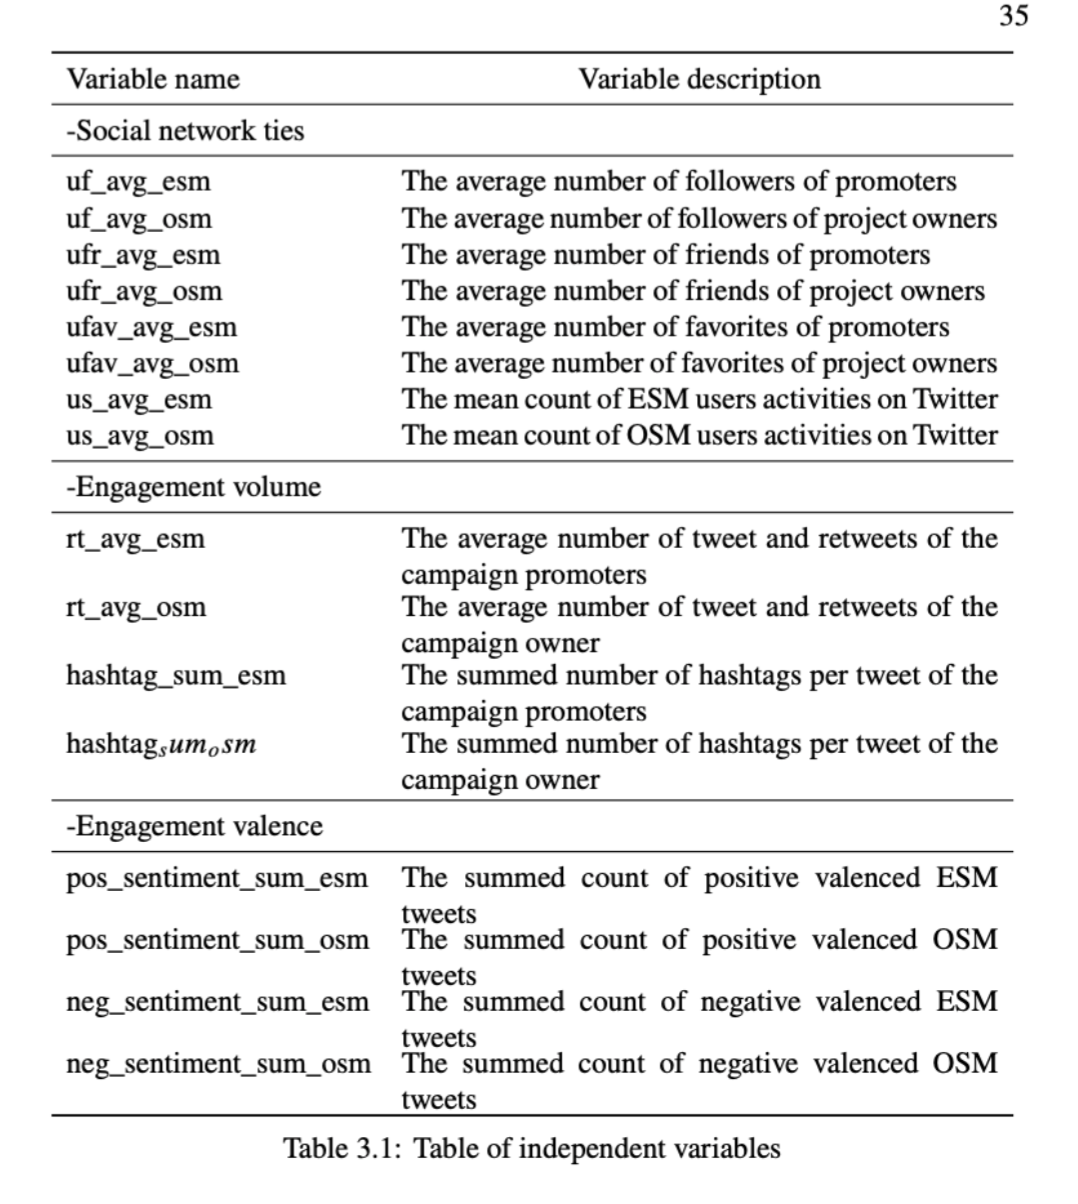




In [82]:
# This will be the size of our tweet basetable
len(output['id'].drop_duplicates())

6219

### tweet_retweet_count

In [19]:
w = Window.partitionBy('id')
tweet_retweet_count_osm = tweets.filter('Same_tweet_creator')\
                .withColumn('rt_sum_osm', F.sum('tweet_retweet_count').over(w))\
                .withColumn('rt_avg_osm', F.avg('tweet_retweet_count').over(w))\
                .select('id','rt_sum_osm','rt_avg_osm')\
                .drop_duplicates()

tweet_retweet_count_esm = tweets.filter(F.col('Same_tweet_creator')==False)\
                .withColumn('rt_sum_esm', F.sum('tweet_retweet_count').over(w))\
                .withColumn('rt_avg_esm', F.avg('tweet_retweet_count').over(w))\
                .select('id','rt_sum_esm','rt_avg_esm')\
                .drop_duplicates()


### User Follower count

In [20]:
w = Window.partitionBy('id')
user_follower_count_osm = tweets.filter('Same_tweet_creator')\
                .withColumn('uf_sum_osm', F.sum('User_followers_count').over(w))\
                .withColumn('uf_avg_osm', F.avg('User_followers_count').over(w))\
                .select('id','uf_sum_osm','uf_avg_osm')\
                .drop_duplicates()

user_follower_count_esm = tweets.filter(F.col('Same_tweet_creator')==False)\
                .withColumn('uf_sum_esm', F.sum('User_followers_count').over(w))\
                .withColumn('uf_avg_esm', F.avg('User_followers_count').over(w))\
                .select('id','uf_sum_esm','uf_avg_esm')\
                .drop_duplicates()




### User_friends_count

In [21]:
w = Window.partitionBy('id')
User_friends_count_osm = tweets.filter('Same_tweet_creator')\
                .withColumn('ufr_sum_osm', F.sum('User_friends_count').over(w))\
                .withColumn('ufr_avg_osm', F.avg('User_friends_count').over(w))\
                .select('id','ufr_sum_osm','ufr_avg_osm')\
                .drop_duplicates()

User_friends_count_esm = tweets.filter(F.col('Same_tweet_creator')==False)\
                .withColumn('ufr_sum_esm', F.sum('User_friends_count').over(w))\
                .withColumn('ufr_avg_esm', F.avg('User_friends_count').over(w))\
                .select('id','ufr_sum_esm','ufr_avg_esm')\
                .drop_duplicates()


### User_favourites_count

In [22]:
w = Window.partitionBy('id')
User_favourites_count_osm = tweets.filter('Same_tweet_creator')\
                .withColumn('ufav_sum_osm', F.sum('User_favourites_count').over(w))\
                .withColumn('ufav_avg_osm', F.avg('User_favourites_count').over(w))\
                .select('id','ufav_sum_osm','ufav_avg_osm')\
                .drop_duplicates()

User_favourites_count_esm = tweets.filter(F.col('Same_tweet_creator')==False)\
                .withColumn('ufav_sum_esm', F.sum('User_favourites_count').over(w))\
                .withColumn('ufav_avg_esm', F.avg('User_favourites_count').over(w))\
                .select('id','ufav_sum_esm','ufav_avg_esm')\
                .drop_duplicates()


### User_status_count

In [23]:
w = Window.partitionBy('id')
User_status_count_osm = tweets.filter('Same_tweet_creator')\
                .withColumn('us_sum_osm', F.sum('User_status_count').over(w))\
                .withColumn('us_avg_osm', F.avg('User_status_count').over(w))\
                .select('id','us_sum_osm','us_avg_osm')\
                .drop_duplicates()

User_status_count_esm = tweets.filter(F.col('Same_tweet_creator')==False)\
                .withColumn('us_sum_esm', F.sum('User_status_count').over(w))\
                .withColumn('us_avg_esm', F.avg('User_status_count').over(w))\
                .select('id','us_sum_esm','us_avg_esm')\
                .drop_duplicates()


### User verified

In [ ]:
tweets['User_verified'].value_counts()

### Media type contains photo

In [25]:
w = Window.partitionBy('id')
Tweet_media_type_photo = tweets.withColumn('Tweet_media_type_photo',
                                           F.when(F.col('Tweet_media_type')=='nan',0).otherwise(1))\
                                .withColumn('Tweet_media_type_photo_sum', F.sum('Tweet_media_type_photo').over(w))\
                                .select('id','Tweet_media_type_photo_sum')\
                                .drop_duplicates()


### Number of hashtags per tweet

In [26]:
hashtags_tweet = tweets.withColumn('Hashtags_count', 
                                   F.size(F.split(F.col('Tweet_hashtags'), ' ')))\
                        .withColumn('Hashtags_sum', F.sum('Hashtags_count').over(w))\
                        .select('id','Hashtags_sum')\
                                .drop_duplicates()

### Text analytics for sentiment analysis
Before we can analyze the text we will provide several text pre-processing steps. 

1.) We will replace the emoticons with text since the emoticons contain a lot of sentiment;

2.) We will not remove any numbers of punctuation since these contain sentiment;

3.) We will not remove stop words as they might contain certain sentiment;

4.) We will not apply lemmatization/stemming since we might lose meaning of the words this way. 


In [27]:

def replace_emoji_text(tweet):
    
    # get all combinations of emoticon and text
    emjoi_text_dicto = demoji.findall(tweet)
    
    # transform emoticon in string with text
    for emjoi, word in emjoi_text_dicto.items():
        tweet = tweet.replace(emjoi, word)
    
    return tweet

In [28]:
replace_emoji_text('Python is 👍')

'Python is thumbs up'

In [29]:
replace_emoji_text_udf = F.udf(replace_emoji_text, StringType())

In [30]:
tweets = tweets.withColumn("tweet_text_clean", replace_emoji_text_udf(F.col("tweet_full_text")))

In [31]:
# define the function to extract the sentiment
def get_sentiment_pos(sentence):
    
    # initialize sentiment analyzer
    sid_obj = SentimentIntensityAnalyzer()

    # get sentiment dict
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    # get positive sentiment score
    pos_sentiment = sentiment_dict["pos"]
    
    # return positive sentiment score
    return(pos_sentiment)

In [32]:
# define the function to extract the sentiment
def get_sentiment_neg(sentence):
    
    # initialize sentiment analyzer
    sid_obj = SentimentIntensityAnalyzer()

    # get sentiment dict
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    # get negative sentiment score
    neg_sentiment = sentiment_dict["neg"]
    
    # return negative sentiment score
    return(neg_sentiment)

In [33]:
# register functions as udf
get_sentiment_pos_udf = F.udf(get_sentiment_pos, DoubleType())
get_sentiment_neg_udf = F.udf(get_sentiment_neg, DoubleType())

In [34]:
# extract positive/negative sentiment score from reviews and store in new columns
tweets = tweets.withColumn("pos_sentiment", get_sentiment_pos_udf("tweet_text_clean"))\
              .withColumn("neg_sentiment", get_sentiment_neg_udf("tweet_text_clean"))

### Get mean and sum of sentiment per project id per OSM/ESM

In [43]:
w = Window.partitionBy('id')
pos_sentiment_osm = tweets.filter('Same_tweet_creator')\
                .withColumn('pos_sentiment_osm_count', F.when(F.col('pos_sentiment') >0.0, 1).otherwise(0))\
                .withColumn('neg_sentiment_osm_count', F.when(F.col('neg_sentiment') > 0.0, 1).otherwise(0))\
                .withColumn('pos_sentiment_osm_sum', F.sum('pos_sentiment_osm_count').over(w))\
                .withColumn('neg_sentiment_osm_sum', F.sum('neg_sentiment_osm_count').over(w))\
                .select('id',"pos_sentiment_osm_sum",'neg_sentiment_osm_sum')\
                .drop_duplicates()

neg_sentiment_esm = tweets.filter(F.col('Same_tweet_creator')==False)\
                .withColumn('neg_sentiment_esm_count', F.when(F.col('neg_sentiment') > 0.0, 1).otherwise(0))\
                .withColumn('pos_sentiment_esm_count', F.when(F.col('pos_sentiment') >0.0, 1).otherwise(0))\
                .withColumn('neg_sentiment_esm_sum', F.sum('neg_sentiment_esm_count').over(w))\
                .withColumn('pos_sentiment_esm_sum', F.sum('pos_sentiment_esm_count').over(w))\
                .select('id',"neg_sentiment_esm_sum",'pos_sentiment_esm_sum')\
                .drop_duplicates()


### Preprocess text data for further analytics

In [36]:
from pyspark.sql.functions import regexp_replace, trim, col, lower
# set column to lower, remove punctuation and numbers
def removePunctuation(column):
    return lower(trim(regexp_replace(column,'\\p{Punct}',''))).alias('sentence')

spark.udf.register('removePunctuation',removePunctuation)


tweets = tweets.withColumn('tweet_text_clean', removePunctuation(tweets.tweet_text_clean))

# remove numbers
tweets = tweets.withColumn('tweet_text_clean', regexp_replace(tweets.tweet_text_clean, '[0-9]',''))

# Twitter data basetable per project id

In [37]:
final_df = pd.read_csv('.\data\basetable_tweets.csv', sep = ';') # kickstarter data with independent and dependent variables 
final_df = final_df[['id']]
final_df = spark.createDataFrame(final_df)

In [44]:
final_df = final_df.join( pos_sentiment_osm, on="id", how="left")\
                          .join( neg_sentiment_esm, on="id", how="left")\
                          .join( tweet_retweet_count_osm, on="id", how="left")\
                          .join( tweet_retweet_count_esm, on="id", how="left")\
                          .join( user_follower_count_osm, on="id", how="left")\
                          .join( user_follower_count_esm, on="id", how="left")\
                          .join( User_friends_count_osm, on="id", how="left")\
                          .join( User_friends_count_esm, on="id", how="left")\
                          .join( User_favourites_count_osm, on="id", how="left")\
                          .join( User_favourites_count_esm, on="id", how="left")\
                          .join( User_status_count_osm, on="id", how="left")\
                          .join( User_status_count_esm, on="id", how="left")\
                          .join( Tweet_media_type_photo, on="id", how="left")\
                          .join( hashtags_tweet, on="id", how="left")\
                          .drop_duplicates()\
                          .cache()

In [45]:
final_df.toPandas().to_csv("final_basetable.csv", sep = ";")